# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum
      - Several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
January, 2022

## Dimuon mass spectrum calculation with Spark DataFrame API

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

import findspark
findspark.init("/home/luca/Spark/spark-3.4.0-SNAPSHOT-bin-20220404")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("dimuon mass")
         .master("local[4]")
         .config("spark.driver.memory", "2g")
         .config("spark.sql.parquet.enableNestedColumnVectorizedReader", "true")
         .getOrCreate()
        )

In [2]:
# Read data with the muon candidate events
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/Spark_Physics

path = "/home/luca/Spark/Spark_Physics/"
df_muons = spark.read.parquet(path + "Run2012BC_DoubleMuParked_Muons.parquet")

df_muons.printSchema()
print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)

Number of events: 61540413


In [3]:
# Apply filters to the input data
# - select only events with 2 muons
# - select only events where the 2 muons have opposite charge

df_muons = df_muons.filter("nMuon == 2").filter("Muon_charge[0] != Muon_charge[1]")


In [4]:
# This computes the 4-vectors sum for the 2 moun system
# using formulas from special relativity, in the limit E >> muons rest mass
# see also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
# and https://en.wikipedia.org/wiki/Invariant_mass

df_with_dimuonmass = df_muons.selectExpr("""
     sqrt(2 * Muon_pt[0] * Muon_pt[1] * 
             ( cosh(Muon_eta[0] - Muon_eta[1]) - cos(Muon_phi[0] - Muon_phi[1]) )
         ) as Dimuon_mass""")

In [5]:
# Compute the histogram of dimuon mass values
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 0.25
max_val = 300
num_bins = 30000
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_with_dimuonmass
        .selectExpr(f"width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")

In [6]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 327 ms, sys: 32.2 ms, total: 359 ms
Wall time: 11.3 s


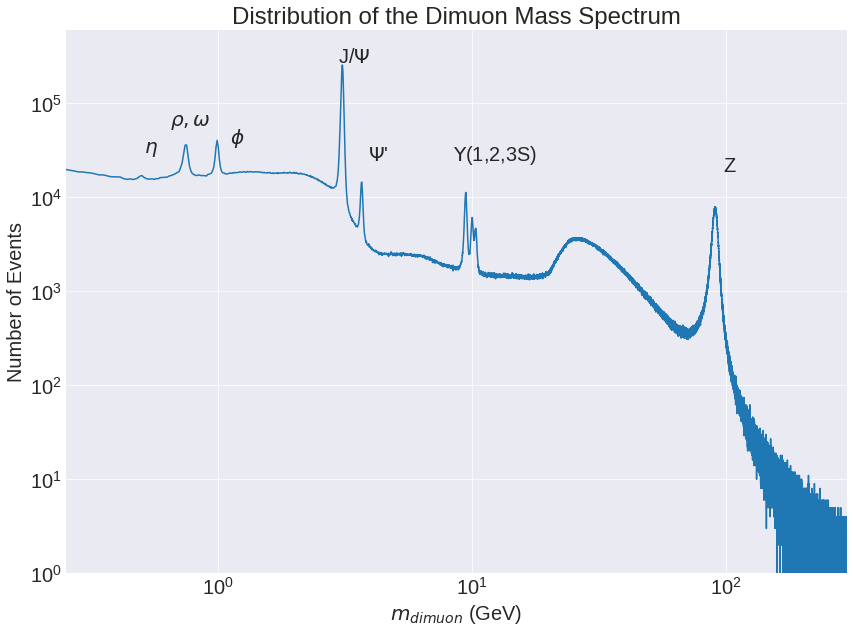

In [7]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()

In [8]:
spark.stop()